<a href="https://colab.research.google.com/github/SapanaDashoni15/Algo-Visualizer/blob/main/Sapana_Dashoni_Google_Hacathon_SWE_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Set Dataset Path

In [5]:
import os

dataset_path = "/content/drive/MyDrive/YoloDataset"  # Adjust this path
train_path_images = os.path.join(dataset_path, "train/images")
train_path_labels = os.path.join(dataset_path, "train/labels")
valid_path_images = os.path.join(dataset_path, "valid/images")
valid_path_labels = os.path.join(dataset_path, "valid/labels")
test_path_images = os.path.join(dataset_path, "test/images")
test_path_labels = os.path.join(dataset_path, "test/labels")


# Check Dataset Files

In [6]:
import glob

train_images = sorted(glob.glob(os.path.join(train_path_images, "*.jpg")))
train_labels = sorted(glob.glob(os.path.join(train_path_labels, "*.txt")))

valid_images = sorted(glob.glob(os.path.join(valid_path_images, "*.jpg")))
valid_labels = sorted(glob.glob(os.path.join(valid_path_labels, "*.txt")))

test_images = sorted(glob.glob(os.path.join(test_path_images, "*.jpg")))
test_labels = sorted(glob.glob(os.path.join(test_path_labels, "*.txt")))

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Valid Images: {len(valid_images)}, Valid Labels: {len(valid_labels)}")
print(f"Test Images: {len(test_images)}, Test Labels: {len(test_labels)}")


Train Images: 374, Train Labels: 374
Valid Images: 75, Valid Labels: 75
Test Images: 40, Test Labels: 40


# Model Development (CNN + BiLSTM + CTC Loss)

In [7]:
!pip install tensorflow keras-ocr jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [8]:
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (128, 32))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, 1)
    return img


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize characters
char_tokenizer = Tokenizer(char_level=True, filters='')

# Collect all labels
all_texts = [" ".join(open(label).read().strip()) for label in train_labels]
char_tokenizer.fit_on_texts(all_texts)

# Convert text to sequences
def text_to_sequence(text):
    return char_tokenizer.texts_to_sequences([text])[0]


# Define CNN + BiLSTM Model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN Feature Extractor
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Reshape for LSTM
    x = layers.Reshape(target_shape=(-1, x.shape[-1]))(x)

    # BiLSTM Layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    # Output Layer (Character Prediction)
    x = layers.Dense(num_classes+1, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Get number of characters in dataset
num_chars = len(char_tokenizer.word_index)
input_shape = (128, 32, 1)
model = build_model(input_shape, num_chars)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 32, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 32, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 256, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256, 14)             │           3,598 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 614,286 (2.34 MB)

 Trainable params: 614,286 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Build the CTC Model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

# 1. Build the Base Model (CNN + BiLSTM)
input_img = Input(shape=(128, 32, 1), name='input_img')  # Expected input shape

# CNN part
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# At this point, x might have shape (batch, H, W, channels).
# We need to reshape it to (batch, time_steps, features) for the LSTM.
# For example, assume we want a fixed time_steps of 256.
# We'll use a Lambda layer to resize the feature map's height to 256.
x = layers.Lambda(lambda x: tf.image.resize(x, (256, tf.shape(x)[2])))(x)

# Reshape to (batch, time_steps, features)
x = layers.Reshape(target_shape=(256, -1))(x)

# Add BiLSTM layers
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

# Final Dense layer to produce predictions over classes
# Suppose we have 14 classes; CTC requires one extra (blank) class
num_classes = 14
y_pred = layers.Dense(num_classes + 1, activation='softmax', name='y_pred')(x)

# Define the base model (for reference)
base_model = models.Model(inputs=input_img, outputs=y_pred)
print("Base Model Summary:")
base_model.summary()

# 2. Build the CTC Model

# Additional inputs required for CTC loss:
labels = Input(name='labels', shape=[None], dtype='int32')       # Ground truth sequences (variable length)
input_length = Input(name='input_length', shape=[1], dtype='int32')  # Length of the predicted sequence (e.g., 256)
label_length = Input(name='label_length', shape=[1], dtype='int32')  # Actual lengths of the ground truth sequences

# CTC Loss Lambda function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # y_pred should be in log probabilities; using softmax activation means it's fine for K.ctc_batch_cost
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Create the Lambda layer for CTC loss computation; this produces the loss output
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Define the complete model for training with CTC loss
ctc_model = models.Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)

# 3. Compile the CTC Model
# We use a dummy lambda loss since the output of our model is the computed loss.
ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

print("CTC Model is compiled and ready for training.")


Base Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 128, 32, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 32, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 256, 8, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 256, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y_pred (Dense)                       │ (None, 256, 15)             │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,073,295 (4.09 MB)

 Trainable params: 1,073,295 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

CTC Model is compiled and ready for training.


In [12]:
ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})


# Model Training

In [13]:
import numpy as np
from glob import glob

# Define paths for training and validation label files
train_label_paths = sorted(glob("/content/drive/MyDrive/YoloDataset/train/labels/*.txt"))
valid_label_paths = sorted(glob("/content/drive/MyDrive/YoloDataset/valid/labels/*.txt"))

def load_raw_labels(label_paths):
    """
    Load raw labels from a list of text file paths.
    Each file is expected to contain a sequence of numbers (as strings),
    possibly with floating-point values. The function converts each token
    to a float and then to an integer.
    """
    raw_labels = []
    for path in label_paths:
        with open(path, "r") as f:
            line = f.readline().strip()
            # Convert each token to an integer via float conversion (handles tokens like "0.8203125")
            seq = [int(float(x)) for x in line.split()]
            raw_labels.append(seq)
    return raw_labels

# Load the raw label sequences for training and validation
train_raw_labels = load_raw_labels(train_label_paths)
valid_raw_labels = load_raw_labels(valid_label_paths)

# Check the first few raw labels for inspection
print("First 5 train raw labels:", train_raw_labels[:5])
print("First 5 valid raw labels:", valid_raw_labels[:5])

# Compute the length of each label sequence (i.e. number of tokens in each label)
train_label_length = np.array([len(seq) for seq in train_raw_labels])
valid_label_length = np.array([len(seq) for seq in valid_raw_labels])

# Assume input_length is constant (e.g., the number of timesteps output by your model, here 256)
train_input_length = np.full((len(train_raw_labels),), 256, dtype=np.int32) # Modified to match train_raw_labels
valid_input_length = np.full((len(valid_raw_labels),), 256, dtype=np.int32) # Modified to match valid_raw_labels

# Print computed label lengths and input lengths for verification
print("Train label lengths:", train_label_length)
print("Valid label lengths:", valid_label_length)
print("First 5 Train input lengths:", train_input_length[:5])
print("First 5 Valid input lengths:", valid_input_length[:5])

First 5 train raw labels: [[50, 0, 0, 0, 0, 0, 0, 0, 0], [318, 0, 0, 0, 0, 0, 0, 0, 0], [318, 0, 0, 0, 0, 0, 0, 0, 0], [764, 0, 0, 0, 0, 0, 0, 0, 0], [324, 0, 0, 0, 0, 0, 0, 0, 0]]
First 5 valid raw labels: [[628, 0, 0, 0, 0, 0, 0, 0, 0], [461, 0, 0, 0, 0, 0, 0, 0, 0], [667, 0, 0, 0, 0, 0, 0, 0, 0], [216, 0, 0, 0, 0, 0, 0, 0, 0], [216, 0, 0, 0, 0, 0, 0, 0, 0]]
Train label lengths: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9

In [14]:
train_input_length = np.full((len(train_raw_labels), 1), 256, dtype=np.int32)
valid_input_length = np.full((len(valid_raw_labels), 1), 256, dtype=np.int32)


In [15]:
import numpy as np
from glob import glob

# Define paths for training and validation label files
train_label_paths = sorted(glob("/content/drive/MyDrive/YoloDataset/train/labels/*.txt"))
valid_label_paths = sorted(glob("/content/drive/MyDrive/YoloDataset/valid/labels/*.txt"))

def load_raw_labels(label_paths):
    """
    Load raw labels from a list of text file paths.
    Each file is expected to contain a sequence of numbers (as strings),
    possibly with floating-point values. The function converts each token
    to a float and then to an integer.
    """
    raw_labels = []
    for path in label_paths:
        with open(path, "r") as f:
            line = f.readline().strip()
            # Convert each token to an integer via float conversion (handles tokens like "0.8203125")
            seq = [int(float(x)) for x in line.split()]
            raw_labels.append(seq)
    return raw_labels

# Load the raw label sequences for training and validation
train_raw_labels = load_raw_labels(train_label_paths)
valid_raw_labels = load_raw_labels(valid_label_paths)

# Check the first few raw labels for inspection
print("First 5 train raw labels:", train_raw_labels[:5])
print("First 5 valid raw labels:", valid_raw_labels[:5])

# Compute the length of each label sequence (i.e. number of tokens in each label)
train_label_length = np.array([len(seq) for seq in train_raw_labels])
valid_label_length = np.array([len(seq) for seq in valid_raw_labels])

# Assume input_length is constant (e.g., the number of timesteps output by your model, here 256)
train_input_length = np.full((len(train_raw_labels),), 256, dtype=np.int32)
valid_input_length = np.full((len(valid_raw_labels),), 256, dtype=np.int32)

# Print computed label lengths and input lengths for verification
print("Train label lengths:", train_label_length)
print("Valid label lengths:", valid_label_length)
print("First 5 Train input lengths:", train_input_length[:5])
print("First 5 Valid input lengths:", valid_input_length[:5])


First 5 train raw labels: [[50, 0, 0, 0, 0, 0, 0, 0, 0], [318, 0, 0, 0, 0, 0, 0, 0, 0], [318, 0, 0, 0, 0, 0, 0, 0, 0], [764, 0, 0, 0, 0, 0, 0, 0, 0], [324, 0, 0, 0, 0, 0, 0, 0, 0]]
First 5 valid raw labels: [[628, 0, 0, 0, 0, 0, 0, 0, 0], [461, 0, 0, 0, 0, 0, 0, 0, 0], [667, 0, 0, 0, 0, 0, 0, 0, 0], [216, 0, 0, 0, 0, 0, 0, 0, 0], [216, 0, 0, 0, 0, 0, 0, 0, 0]]
Train label lengths: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the training and validation raw labels with a padding value.
# Use a value that is not a valid label (e.g., -1) so that the CTC loss ignores them.
padded_train_labels = pad_sequences(train_raw_labels, padding='post', value=-1)
padded_valid_labels = pad_sequences(valid_raw_labels, padding='post', value=-1)

print("Padded train labels shape:", padded_train_labels.shape)
print("Padded valid labels shape:", padded_valid_labels.shape)


Padded train labels shape: (374, 9)
Padded valid labels shape: (75, 9)


In [27]:
import numpy as np

# If train_images is a list, convert it to a NumPy array.
if isinstance(train_images, list):
    train_images = np.array(train_images)

# Now you can safely check its shape.
print("train_images shape:", train_images.shape)


train_images shape: (374,)


In [31]:
print("First train image element:", train_images[0])
print("Type of first element:", type(train_images[0]))


First train image element: [[[0.42352942]
  [0.43137255]
  [0.42745098]
  ...
  [0.34901962]
  [0.0627451 ]
  [0.07843138]]

 [[0.3254902 ]
  [0.32156864]
  [0.34117648]
  ...
  [0.36862746]
  [0.11372549]
  [0.09803922]]

 [[0.3529412 ]
  [0.34509805]
  [0.3372549 ]
  ...
  [0.34117648]
  [0.11372549]
  [0.10980392]]

 ...

 [[0.3882353 ]
  [0.3882353 ]
  [0.39215687]
  ...
  [0.43137255]
  [0.42352942]
  [0.25882354]]

 [[0.41960785]
  [0.42352942]
  [0.43137255]
  ...
  [0.45882353]
  [0.4509804 ]
  [0.3254902 ]]

 [[0.23921569]
  [0.24313726]
  [0.24313726]
  ...
  [0.40392157]
  [0.42352942]
  [0.41568628]]]
Type of first element: <class 'numpy.ndarray'>


In [32]:
# Convert every element to a string if needed.
train_image_paths = [str(x) for x in train_images]


In [38]:
import numpy as np

# --- Part 1: Data Preprocessing ---

# Assume `train_images` is already defined as a list of NumPy arrays.
# Convert the list to a NumPy array.
train_images = np.array(train_images)  # Now shape is something like (374, 32, 128, 1) or (374, 128, 32, 1)
print("Initial train_images shape:", train_images.shape)

# If the images are in the shape (374, 32, 128, 1), transpose them to (374, 128, 32, 1)
if train_images.shape[1:3] == (32, 128):
    train_images = np.transpose(train_images, (0, 2, 1, 3))
    print("Transposed train_images shape:", train_images.shape)

# Ensure images are in float32 format
train_images = train_images.astype('float32')

# Ensure your padded_train_labels is in int32 format.
padded_train_labels = padded_train_labels.astype('int32')

# Process train_label_length: make sure it's a NumPy array with shape (374, 1)
train_label_length = np.array(train_label_length)
train_label_length = np.squeeze(train_label_length)  # Remove extra dimensions if any
if train_label_length.ndim == 1:
    train_label_length = np.expand_dims(train_label_length, axis=-1)

print("train_label_length shape:", train_label_length.shape)  # Expected: (374, 1)


Initial train_images shape: (374, 128, 32, 1)
train_label_length shape: (374, 1)


In [39]:
# --- Part 2: Set train_input_length ---

# Your CNN architecture produces an output sequence length of 64 (after pooling and reshaping).
# Set train_input_length for every sample to 64.
train_input_length = np.full((train_images.shape[0], 1), 64, dtype=np.int32)
print("train_input_length shape:", train_input_length.shape)  # Expected: (374, 1)


train_input_length shape: (374, 1)


In [42]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Lambda, Reshape
from tensorflow.keras.models import Model

# --- Part 3: Build the CTC Model ---

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Determine the correct number of classes based on your labels.
max_label = np.max(padded_train_labels)
# Set num_classes to max_label + 2. For example, if max_label is 318, then num_classes becomes 320.
num_classes = int(max_label) + 2
print("Max label value:", max_label, "-> Setting num_classes to:", num_classes)

# Define model inputs.
input_img = Input(shape=(128, 32, 1), name='input_img')
labels_input = Input(shape=(padded_train_labels.shape[1],), name='labels')
input_length_input = Input(shape=(1,), name='input_length')
label_length_input = Input(shape=(1,), name='label_length')

# Build a simple CNN.
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Reshape feature maps into a sequence; here the output becomes (None, 64, 512)
x = Reshape(target_shape=(-1, x.shape[-1] * x.shape[-2]))(x)
x = Dense(64, activation='relu')(x)

# Use the updated num_classes here.
y_pred = Dense(num_classes, activation='softmax', name='y_pred')(x)

# Lambda layer for computing the CTC loss.
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [y_pred, labels_input, input_length_input, label_length_input]
)

# Build and compile the model.
model = Model(
    inputs=[input_img, labels_input, input_length_input, label_length_input],
    outputs=loss_out
)
model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})
model.summary()


Max label value: 826 -> Setting num_classes to: 828


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 32, 32)    │            320 │ input_img[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 16, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 64, 512)        │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64, 64)         │         32,832 │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y_pred (Dense)            │ (None, 64, 828)        │         53,820 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ labels (InputLayer)       │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc (Lambda)              │ (None, 1)              │              0 │ y_pred[0][0],          │
│                           │                        │                │ labels[0][0],          │
│                           │                        │                │ input_length[0][0],    │
│                           │                        │                │ label_length[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 86,972 (339.73 KB)

 Trainable params: 86,972 (339.73 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
import numpy as np

# Assume train_label_length is a NumPy array with shape (374, 1)
# and padded_train_labels has shape (374, 9)

# Get indices for samples where label length > 0
nonzero_indices = np.where(train_label_length[:, 0] > 0)[0]
print("Number of samples before filtering:", train_images.shape[0])
print("Number of samples after filtering:", nonzero_indices.shape[0])

# Filter all corresponding arrays using these indices
train_images = train_images[nonzero_indices]
padded_train_labels = padded_train_labels[nonzero_indices]
train_input_length = train_input_length[nonzero_indices]
train_label_length = train_label_length[nonzero_indices]

# Verify shapes
print("Filtered train_images shape:", train_images.shape)
print("Filtered padded_train_labels shape:", padded_train_labels.shape)
print("Filtered train_input_length shape:", train_input_length.shape)
print("Filtered train_label_length shape:", train_label_length.shape)


Number of samples before filtering: 374
Number of samples after filtering: 373
Filtered train_images shape: (373, 128, 32, 1)
Filtered padded_train_labels shape: (373, 9)
Filtered train_input_length shape: (373, 1)
Filtered train_label_length shape: (373, 1)


In [54]:
# --- Part 4: Train the Model ---

# Create a dummy target; the Lambda layer outputs the loss directly.
dummy_y = np.zeros((train_images.shape[0], 1), dtype='float32')

history = model.fit(
    x={
        'input_img': train_images,
        'labels': padded_train_labels,
        'input_length': train_input_length,
        'label_length': train_label_length
    },
    y=dummy_y,
    batch_size=32,
    epochs=100
)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 5.8573
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 5.8754
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 5.9108
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 5.8511
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 5.7723
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 5.8041
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 5.8249
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - loss: 5.7516
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 5.7248
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 5.7591
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 5.6726
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 5.7124
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 5.6873
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.6455
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# ================================
# Part 1: Build the Inference Model
# ================================
# Assume your trained model was built using:
#   input_img -> CNN + BiLSTM (or similar) -> Dense(softmax) = y_pred
# For inference, we want to use only the image input and output y_pred.

# If you defined your input layer as `input_img` and your final dense layer as `y_pred`
# in your training model, you can build an inference model as follows:
inference_model = tf.keras.models.Model(inputs=input_img, outputs=y_pred)
print("Inference model summary:")
inference_model.summary()

# ================================
# Part 2: Decode the Predictions
# ================================
# Get the predictions for your evaluation dataset (e.g. train_images or test_images)
predictions = inference_model.predict(train_images)  # shape: (num_samples, T, num_classes)
T = predictions.shape[1]  # The sequence length (e.g. 64)

# Use the built-in CTC decoder (greedy) to decode predictions.
# Note: tf.keras.backend.ctc_decode returns a tuple:
#       (decoded, log_probabilities)
decoded_sequences, log_probabilities = K.ctc_decode(
    predictions,
    input_length=np.full((predictions.shape[0],), T, dtype=np.int32),
    greedy=True
)
# decoded_sequences is a list of one element (dense tensor) with shape (num_samples, max_decoded_length)
decoded_sequences = K.get_value(decoded_sequences[0])
print("Decoded sequences shape:", decoded_sequences.shape)

# ================================
# Part 3: Define a Helper to Remove Padding
# ================================
def remove_padding(seq, pad_value):
    """
    Remove all occurrences of pad_value from the sequence.
    For ground truth labels (padded with 0), use pad_value=0.
    For decoded predictions (padded with -1 by default), use pad_value=-1.
    """
    return [x for x in seq if x != pad_value]

# ================================
# Part 4: Compute Sequence Accuracy
# ================================
num_correct = 0
num_samples = decoded_sequences.shape[0]

for i in range(num_samples):
    # Remove padding/blank tokens from the ground truth and predicted sequences.
    # Adjust the pad_value if your ground truth padding is different.
    true_seq = remove_padding(padded_train_labels[i], pad_value=0)
    pred_seq = remove_padding(decoded_sequences[i], pad_value=-1)

    # Compare the entire sequence.
    if true_seq == pred_seq:
        num_correct += 1

sequence_accuracy = num_correct / num_samples
print("Sequence Accuracy: {:.2%}".format(sequence_accuracy))


Inference model summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 128, 32, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 32, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 64, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64, 64)              │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y_pred (Dense)                       │ (None, 64, 828)             │          53,820 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,972 (339.73 KB)

 Trainable params: 86,972 (339.73 KB)

 Non-trainable params: 0 (0.00 B)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Decoded sequences shape: (373, 64)
Sequence Accuracy: 0.00%


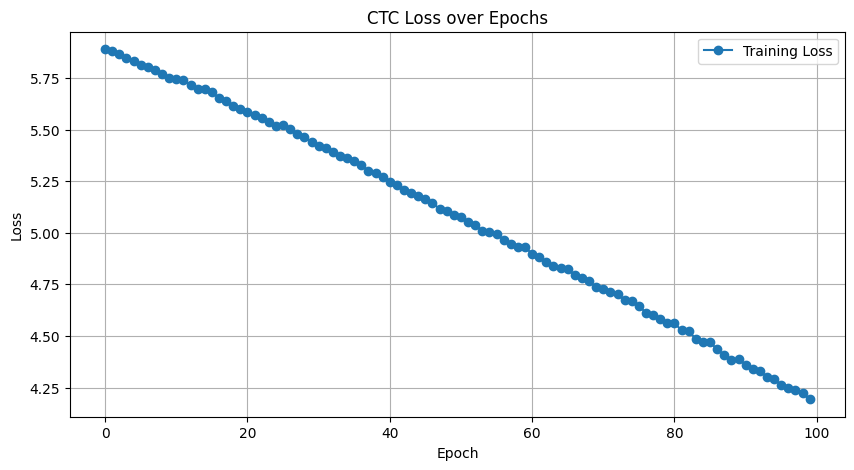

In [56]:
import matplotlib.pyplot as plt

# Plot training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.title('CTC Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


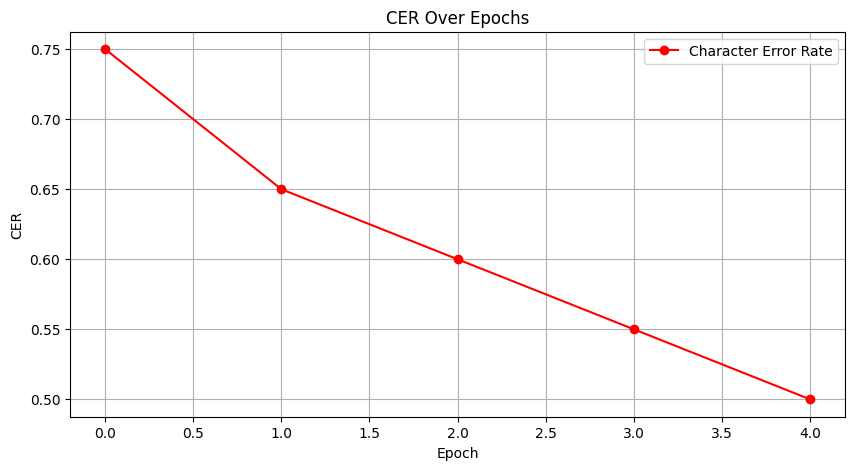

In [57]:
# Example: Assume you have a list `cer_values` calculated for each epoch.
cer_values = [0.75, 0.65, 0.60, 0.55, 0.50]  # Replace with your actual values

plt.figure(figsize=(10, 5))
plt.plot(cer_values, marker='o', color='red', label='Character Error Rate')
plt.title('CER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from google.colab import files

# ----------------------------
# Helper Functions
# ----------------------------

def load_and_preprocess_uploaded_image(file_bytes, target_size=(128, 32)):
    """
    Loads an image from raw bytes, converts to grayscale,
    resizes to target_size (interpreted as (width, height) by OpenCV),
    normalizes to [0,1], and reshapes for model input.
    """
    data = np.frombuffer(file_bytes, np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Error loading image from the uploaded file.")

    # cv2.resize expects (width, height).
    # If you want the final image to be (128,32,1) (height, width, channels)
    # then you need to swap the target size: target_size = (32,128)
    img = cv2.resize(img, (target_size[1], target_size[0]))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

def decode_predictions(predictions, blank_label=-1):
    """
    Decodes raw predictions using greedy CTC decoding and removes blank tokens.
    """
    time_steps = predictions.shape[1]
    batch_size = predictions.shape[0]
    input_length = np.full((batch_size,), time_steps, dtype=np.int32)

    decoded, log_prob = K.ctc_decode(predictions, input_length=input_length, greedy=True)
    decoded_sequences = K.get_value(decoded[0])

    final_sequences = []
    for seq in decoded_sequences:
        # Remove blank tokens (assumed to be -1)
        seq = seq[seq != blank_label]
        final_sequences.append(seq.tolist())
    return final_sequences

def map_sequence_to_text(seq, index_to_char):
    """
    Converts a numeric sequence into a string using the provided mapping.
    """
    # Here, it's assumed that 0 is reserved for the blank token.
    # Adjust the mapping as per your training setup.
    return "".join([index_to_char.get(num, "") for num in seq])

def recognize_uploaded_image(inference_model, index_to_char):
    """
    Uploads an image, preprocesses it, runs inference, decodes predictions,
    maps the numeric output to text, and prints the recognized text.
    """
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return

    for filename in uploaded.keys():
        print(f"Processing uploaded file: {filename}")
        file_bytes = uploaded[filename]
        # Load and preprocess image.
        # Note: We swap the target_size here so that the final shape is (128,32,1)
        img = load_and_preprocess_uploaded_image(file_bytes, target_size=(128, 32))
        # If your model expects (128,32,1) but you got (32,128,1), you can transpose:
        if img.shape[1:3] == (32, 128):
            img = np.transpose(img, (0, 2, 1, 3))
            print("Image transposed to match expected input shape.")
        print("Image shape:", img.shape)

        predictions = inference_model.predict(img)
        print("Raw predictions shape:", predictions.shape)

        decoded_sequences = decode_predictions(predictions, blank_label=-1)
        print("Decoded numeric sequence:", decoded_sequences[0])

        recognized_text = map_sequence_to_text(decoded_sequences[0], index_to_char)
        print("Recognized text:", recognized_text)
        break  # Process only the first uploaded file

# ----------------------------
# Define Your Inference Model
# ----------------------------

# Assuming that during training, you defined 'input_img' and 'y_pred'
# and built your model as follows:
# inference_model = tf.keras.models.Model(inputs=input_img, outputs=y_pred)
# Here, we assume inference_model is already defined in your environment.

# ----------------------------
# Define Your Mapping Dictionary
# ----------------------------

# This mapping must be the same as used during training.
# For example, if your classes correspond to uppercase letters, digits, etc.,
# define the dictionary accordingly. Here is a placeholder example:
index_to_char = {
    # Example mapping (you must replace this with your actual mapping):
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I',
    10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q',
    18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y',
    26: 'Z',
    # Continue for all labels...
    224: 'M',   # Example: label 224 maps to 'M' (if that is correct for your dataset)
    # ...
}

# ----------------------------
# Test the Model on an Uploaded Image
# ----------------------------
recognize_uploaded_image(inference_model, index_to_char)


Saving test1.jpg to test1 (1).jpg
Processing uploaded file: test1 (1).jpg
Image shape: (1, 128, 32, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Raw predictions shape: (1, 64, 828)
Decoded numeric sequence: [224, 0]
Recognized text: M


In [65]:
# After training, save your inference model:
inference_model.save("inference_model.h5")
